# Premise of Notebook

Home-field advantage is a long acknowleged phenomenon in football. While there is empirical evidence for this phenomenon, there is little understanding of the underlying factors that cause it. This notebook will attempt to randomly generate league data for teams based on characteristics determined by real world data. Data will be analysed and generated across six variables: goals scored at home, goals conceded at home, points gained at home, goals scored away from home, goals conceded away from home, and points gained away from home. I will first analyse real world data for the 2018/19 season of the English Premier League in order to establish teams performance at home and away from home. The dataset used is an existing dataset that I had created based on the results of the last Premier League season.

Performances at home tend to be better than performances away from home, teams score more goals, and concede fewer, leading to more points gained. Initial analysis will be carried out on the dataset, examining the goals scored and conceded, goal difference, and points gained at home and away from home in the real world dataset.

When that analysis has been completed random data will be generated, using the numpy package, to simulate a league table with those variables.

# Methodology

Home and away league tables are available [here](https://www.soccerstats.com/homeaway.asp?league=england_2019). Viewing these tables as far back as the 2011/12 season supports the fact that teams perform better at home. For example, the 2018/19, which will be the my basis for generating random data, all but one team(Crystal Palace) gained more points per game at home than away.

The first variables that will be examined are the goals scored and conceded at home. The real world values will be used to calculate attacking and defensive coefficients than can be used as parameters when genereting random data. The goals scored and conceded away from home will be generated in much the same way; however this data will have to be normalised so that it is equal to thwe number of goals scored and conceded at home.

Finally, the distribution of points across the league will be established. Once a suitable distribution is identiifed it can be used to generate point totals for each team.

In [1]:
# import python packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from iteround import saferound

# matplotlib magic command to make sure plots appear inline
%matplotlib inline

# set seaborn colour codes and palette
sns.set(color_codes=True)
sns.set_palette("Set2");

In [2]:
# import truncted norm form scipy
from scipy.stats import truncnorm

# truncated norm function https://stackoverflow.com/a/44308018
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# 1. Real World Data

In [3]:
# imported csv 
pl = pd.read_csv("league_table.csv", index_col="Team", names=["Team", "Home(F)", "Home(A)", "Points(H)", "Away(F)", "Away(A)", "Points(A)" ]);

In [4]:
# added new column of total goals scored
pl["Total(F)"] = pl["Home(F)"] + pl["Away(F)"]
# added new column of total goals conceded
pl["Total(A)"] = pl["Home(A)"] + pl["Away(A)"]
# added new column of difference between goals scored and conceded
pl["Total(Dif)"]= pl["Total(F)"] - pl["Total(A)"]
# added new column with total points
pl["Total(P)"] = pl["Points(H)"] + pl["Points(A)"]

# created dataframe with total goals for, against, difference, and total points
total = pl[["Total(F)", "Total(A)", "Total(Dif)", "Total(P)"]]
total = total.sort_values(by = "Total(P)", ascending=False);
total

,Total(F),Total(A),Total(Dif),Total(P)
Team,,,,
Manchester City,95,23,72,98
Liverpool,89,22,67,97
Chelsea,63,39,24,72
Tottenham,67,39,28,71
Arsenal,73,51,22,70
Manchester United,65,54,11,66
Wolves,47,46,1,57
Everton,54,46,8,54
Leicester City,51,48,3,52


The original dataset only contains data seperated by home and away tables. As such, a combined dataframe was created. This dataframe will used as a reference point for the randomly generated league table.

In [5]:
# description of total table
total.describe()

,Total(F),Total(A),Total(Dif),Total(P)
count,20.000000,20.000000,20.000000,20.000000
mean,53.600000,53.600000,0.000000,53.450000
std,18.071204,15.752694,32.371202,21.007455
min,22.000000,22.000000,-54.000000,16.000000
25%,44.250000,46.000000,-20.750000,39.750000
50%,51.500000,53.500000,-2.500000,51.000000
75%,63.500000,65.750000,13.750000,67.000000
max,95.000000,81.000000,72.000000,98.000000


This data may be useful later as a point of comparison to the randomly generated data. There is one thing that jumps out as a factor that needs to be considered; the mean goal difference is 0. This makes sense, all the goals scored must correspond to a goal conceded by another team. Therefore, when generating away goal data it will be import to normalise the data so that it equals its corresponding random home value.

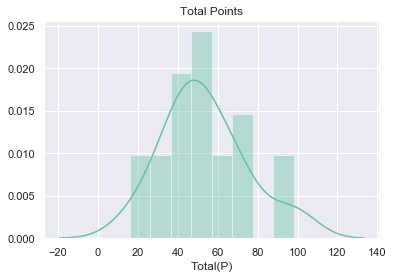

In [6]:
# distribution of total points
sns.distplot(total["Total(P)"], bins=8)
plt.title("Total Points");

The distribution of points seems to follow a normal(gaussian) distribution. This can be confirmed by running a [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro–Wilk_test), which test whether samples came from a normal distribution.

In [7]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

from scipy.stats import shapiro

stat, p = shapiro(total["Total(P)"])

alpha = 0.05

if p > alpha:
    print("Points Distribution appears to be Gaussian")
else:
    print("Points distribution does not appear to be Gaussian")

Points Distribution appears to be Gaussian


This means that a normal distribution in numpy can be used to generate a teams points total.

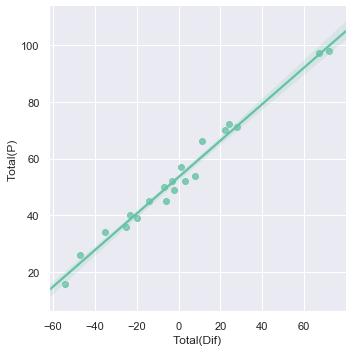

In [8]:
# regression plot between goal difference and total points
sns.lmplot(x="Total(Dif)", y="Total(P)", data=total);

There is a strong correlation between a team's goal difference and total points. Once random goal data has been generated for all teams, the goal difference may be used as the order in which to assign the points to teams.

## Home

In [9]:
# added new column with home goal difference
pl["Home(Dif)"] = pl["Home(F)"] - pl["Home(A)"]
# created league table based on home form
home = pl[["Home(F)", "Home(A)", "Home(Dif)", "Points(H)"]]
# sorted league table by points
home = home.sort_values(by = "Points(H)", ascending=False);
home

,Home(F),Home(A),Home(Dif),Points(H)
Team,,,,
Manchester City,57,12,45,54
Liverpool,55,10,45,53
Arsenal,42,16,26,45
Chelsea,39,12,27,42
Tottenham,34,16,18,38
Manchester United,33,25,8,36
Wolves,28,21,7,34
Everton,30,21,9,34
West Ham,32,27,5,31


In [10]:
# description of home stats
home.describe()

,Home(F),Home(A),Home(Dif),Points(H)
count,20.000000,20.000000,20.000000,20.000000
mean,29.800000,23.800000,6.000000,30.700000
std,11.542142,7.878017,18.381913,11.494163
min,10.000000,10.000000,-21.000000,9.000000
25%,23.500000,19.000000,-5.000000,23.000000
50%,27.500000,25.000000,4.500000,28.000000
75%,33.250000,28.500000,11.250000,36.500000
max,57.000000,38.000000,45.000000,54.000000


## Away

In [11]:
# added new column with away goal difference
pl["Away(Dif)"] = pl["Away(F)"] - pl["Away(A)"]
# created league table based on away form
away = pl[["Away(F)", "Away(A)", "Away(Dif)", "Points(A)"]]
# sorted league table by points
away = away.sort_values(by="Points(A)", ascending=False);
away

,Away(F),Away(A),Away(Dif),Points(A)
Team,,,,
Manchester City,38,11,27,44
Liverpool,34,12,22,44
Tottenham,33,23,10,33
Chelsea,24,27,-3,30
Manchester United,32,29,3,30
Crystal Palace,32,30,2,29
Leicester City,27,28,-1,25
Arsenal,31,35,-4,25
Watford,26,31,-5,23


In [12]:
# description of away stats
away.describe()

,Away(F),Away(A),Away(Dif),Points(A)
count,20.000000,20.000000,20.000000,20.000000
mean,23.800000,29.800000,-6.000000,22.750000
std,7.831112,9.225822,15.245362,10.361238
min,12.000000,11.000000,-33.000000,5.000000
25%,18.000000,25.000000,-16.250000,16.000000
50%,24.000000,29.500000,-5.000000,22.000000
75%,31.250000,35.000000,-0.250000,29.250000
max,38.000000,45.000000,27.000000,44.000000


The descriptive statistics for the home and away tables identified some characteristics that may be useful. First of all, the total goals scored and conceded by each team in these tables may be usable as parameters in generating random data. One way of doing this would be to pass each total as a parameter in a numpy.random function. However, the way I have decided to do this instead is to calculate a coefficient for each teams attacking and defensive abilities that may add more variance to the randomly generated data.

## Home vs. Away

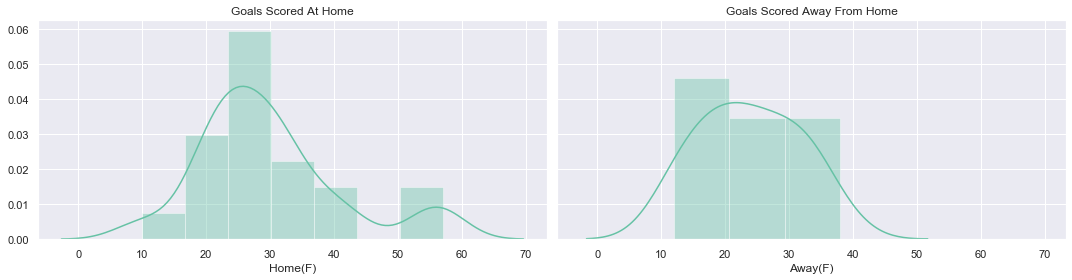

In [13]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of goals scored at home
sns.distplot(home["Home(F)"], ax=axes[0])
axes[0].set_title("Goals Scored At Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Away(F)"], ax= axes[1])
axes[1].set_title("Goals Scored Away From Home");

plt.tight_layout()

There is a marked difference between the number, and distribution, of goals scored at home and away from home; more teams score are higher number of goals at home.  This difference will have to be accounted for when generating random data for goals scored.

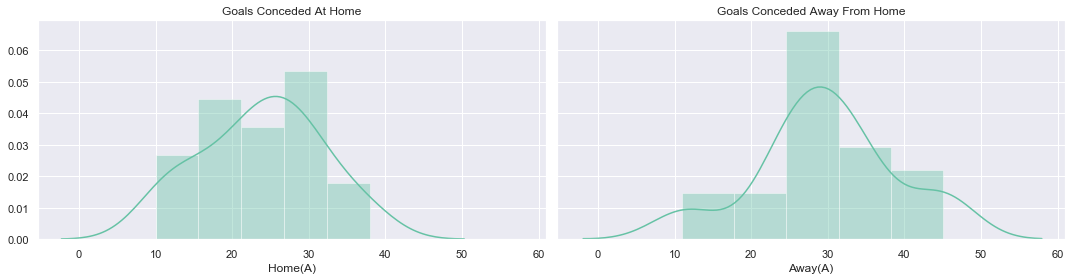

In [14]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of goals conceded at home
sns.distplot(home["Home(A)"], ax=axes[0])
axes[0].set_title("Goals Conceded At Home");

# distibution of goals conceded away from home 
sns.distplot(away["Away(A)"], ax= axes[1])
axes[1].set_title("Goals Conceded Away From Home");

plt.tight_layout()


This is also true when looking at goals conceded; more teams concede fewer goals at home.

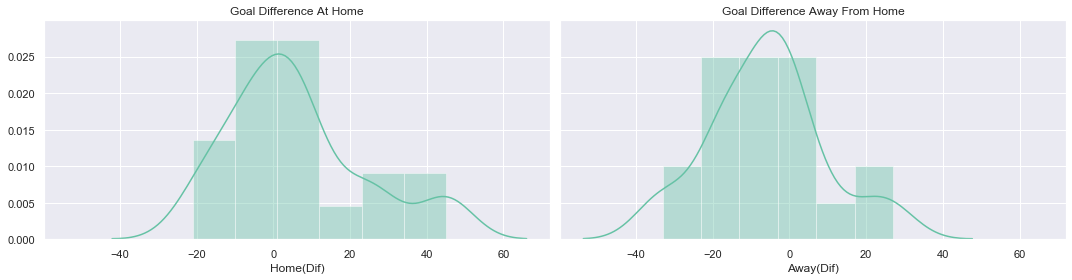

In [15]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of goals difference at home
sns.distplot(home["Home(Dif)"], ax=axes[0])
axes[0].set_title("Goal Difference At Home");

# distibution of goals difference away from home 
sns.distplot(away["Away(Dif)"], ax= axes[1])
axes[1].set_title("Goal Difference Away From Home");

plt.tight_layout()

Logically, it follows that this difference is evident when viewing goal difference at home and away from home.

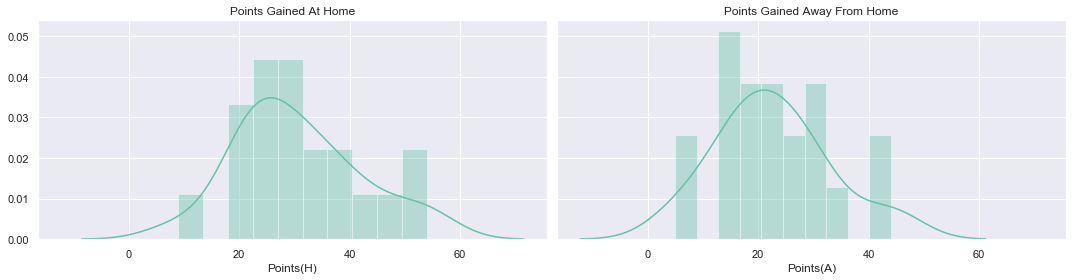

In [16]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of goals scored at home
sns.distplot(home["Points(H)"], bins= 10, ax=axes[0])
axes[0].set_title("Points Gained At Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Points(A)"], bins= 10, ax= axes[1])
axes[1].set_title("Points Gained Away From Home");

plt.tight_layout()


The points gained at home higher and have a greater density at the higher numbers also.

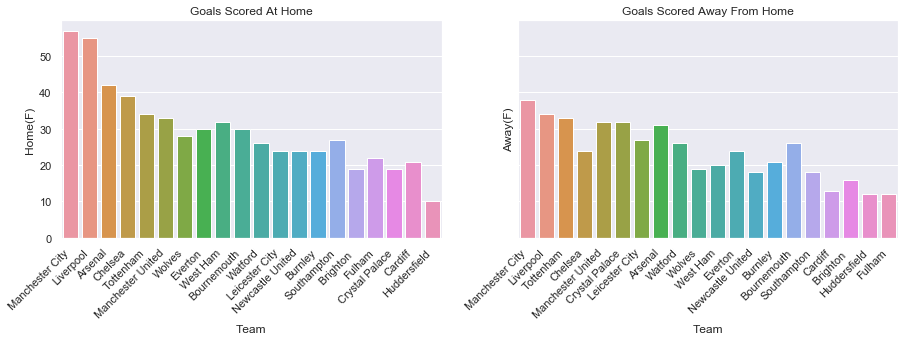

In [17]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goals scored at home
goals_for = sns.catplot(x="Team", y="Home(F)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Scored At Home");

# distibution of goals scored away from home 
goals_for = sns.catplot(x="Team", y="Away(F)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Scored Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

These plots give a more comparative look at the difference in goals scored at home and away from home.

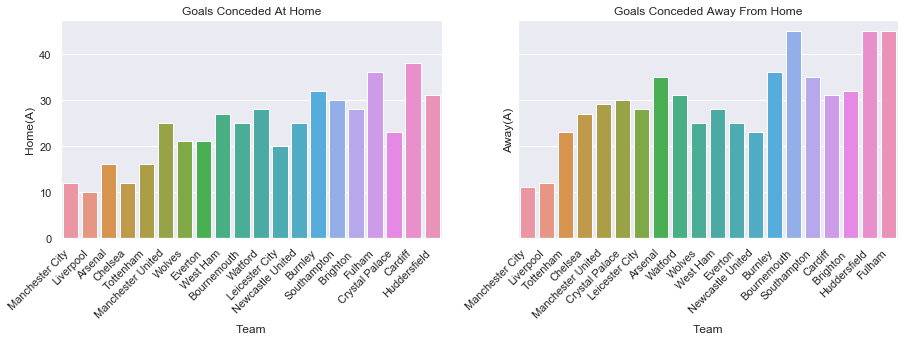

In [18]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goals conceded at home
goals_for = sns.catplot(x="Team", y="Home(A)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Conceded At Home");

# distibution of goals conceded away from home 
goals_for = sns.catplot(x="Team", y="Away(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Conceded Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

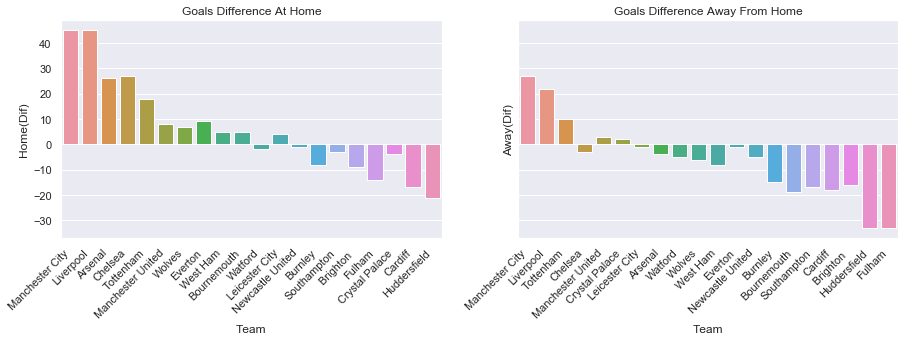

In [19]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goal difference at home
goals_for = sns.catplot(x="Team", y="Home(Dif)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Difference At Home");

# distibution of goal difference away from home 
goals_for = sns.catplot(x="Team", y="Away(Dif)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Difference Away From Home");

plt.tight_layout()

# closed empty plots  
plt.close(2)
plt.close(3)

This is further evident when viewing goal difference, with far more teams having a minus goal difference away from home.

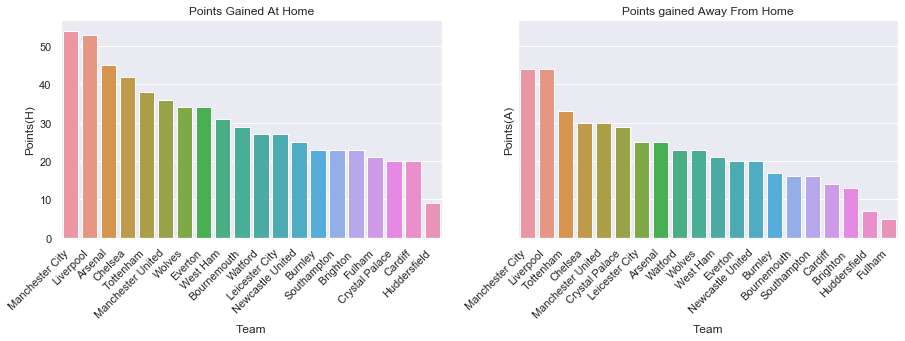

In [20]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# bar plot of points gained at home
goals_for = sns.catplot(x="Team", y="Points(H)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Points Gained At Home");

# bar plot of points gained away from home 
goals_for = sns.catplot(x="Team", y="Points(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Points gained Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

And again we can see that almost all teams have accumulated less points away from home.

## Characteristics To Consider When Generating Random Data

Due to marked difference between home and away form the random data will be generated under different parameters for home and away before being combined into a total table at the end. Each team will be assigned an attacking coefficient based on the number of goals scored at home divided by the number of games played at home. This number will then be divided by the average number of home goals score per game across the league. This coefficient will be used as a parameter when generating the number of goals scored by each team.

A defensive coefficient will similarily be assigned based on the number of goals conceded by a team at home divided by the number of games played at home. This number will then be divided by the average number of goals conceded per game across the team.

The same model will then be applied to a team's away data. Once random goal data has been generated, each team's goal difference will be calculated. As noted previously, a higher goal difference correlates with a higher points total. As such, once points have been randomly generated for each team they will be assigned based on goal difference.

## Which Distributions To Use

Upon researching different distributions available in numpy for generating random goal data it was decided the the [poisson distribution](https://docs.scipy.org/doc/numpy-1.14.1/reference/generated/numpy.random.poisson.html) was the most suitable. The poisson distribution accepts two inputs; lam, the expection of interval, and the size of the output. The coefficients mentioned in the previous section can be used to generate the lam values and the output size will be the number of teams in the league.

When researching the poisson distribution and its potential use in this notebook I became aware of its use as a model in match betting. [This blog post](https://www.betfair.com.au/hub/poisson-distribution/) on betfair.com documents the use of the poisson distribution in predicting the result of a single match. I have extrapolated out this method and added elements of it to the method proposed above. Rather than apply this to the result of a single match my goal is to randomly generate the number of goals a team has scored or conceded over a 19 match period.

In [21]:
# example
np.random.poisson(lam=(10,25,19,13,33,23,11,34,21,31,11,22,33,44,55,12,17,8,15,5), size=(20))

array([ 8, 30, 19, 18, 32, 12,  8, 37, 22, 29, 12, 19, 23, 61, 47, 12, 18,
        5, 10, 10])

As it has been established that the distribution of points follows a gaussian distribution the [nump.random.normal distribution](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.normal.html) was initially chosen to generate this data. However, the normal distribution can also generate negative numbers. Upon further research, the scipy package [truncnorm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html), which allows lower and upper limits to be placed when generating numbers in the normal distribution, was chosen. The minimum number of points was set to 0, and the maximum was set to 57. This is to account to the maximum number of points that teams can accrue at home or away from home, 3 points for a win with 19 games played at home and 19 games played away from home.

# 2. Random Data

In [22]:
# imported blank league table in alphabetical order
pl_new = pd.read_csv("league_table_blank.csv", index_col="Team", names=["Team", "Home(F)", "Home(A)", "Away(F)", "Away(A)"]);

## Random Home Data

The first step was to generate random home goal data, both goals scored and conceded. The steps to this include:
- Calculating the mean home goals scored across the league.
- Calculating the mean home goals per match.
- Dividing each teams goals per game by the average goals per game
- Multiplying the result by the average goals scored at home 
- Each team's value was then used in the poisson distribution the generate random values

The same method was also used for goals conceded.

### Goals Scored

In [23]:
# mean of home goals scored  
home["Home(F)"].mean()

29.8

Here we have the mean data of goals scored. This will be needed to calculate the coefficients of each team.

In [24]:
# real world values of goals scored at home 
home = home.sort_values(by = "Team")
home["Home(F)"]

Team
Arsenal              42
Bournemouth          30
Brighton             19
Burnley              24
Cardiff              21
Chelsea              39
Crystal Palace       19
Everton              30
Fulham               22
Huddersfield         10
Leicester City       24
Liverpool            55
Manchester City      57
Manchester United    33
Newcastle United     24
Southampton          27
Tottenham            34
Watford              26
West Ham             32
Wolves               28
Name: Home(F), dtype: int64

In [25]:
# average goals scored by home team per home game
home["Home(F)"].mean()/19

1.568421052631579

In [26]:
# array of home team's goals scored 
home_ac = home["Home(F)"]
# divided goals by number of games 
home_ac = np.divide(home_ac, 19)

# divided by average of goal per game and multiplied by average goals 
home_ac = (np.divide(home_ac, 1.57))*29.8

# added home goals scored to dataframe
pl_new["Home(F)"] = np.random.poisson(lam=home_ac, size=(20))

pl_new["Home(F)"]

Team
Arsenal              37
Bournemouth          25
Brighton             12
Burnley              22
Cardiff              21
Chelsea              39
Crystal Palace       21
Everton              31
Fulham               18
Huddersfield          9
Leicester City       22
Liverpool            57
Manchester City      46
Manchester United    25
Newcastle United     36
Southampton          31
Tottenham            36
Watford              25
West Ham             30
Wolves               19
Name: Home(F), dtype: int64

### Goals Conceded

In [27]:
# mean of goals conced at home across the league
home["Home(F)"].mean()

29.8

In [28]:
# real world values of goals conceded by teams at home
home = home.sort_values(by = "Team")
home["Home(A)"]

Team
Arsenal              16
Bournemouth          25
Brighton             28
Burnley              32
Cardiff              38
Chelsea              12
Crystal Palace       23
Everton              21
Fulham               36
Huddersfield         31
Leicester City       20
Liverpool            10
Manchester City      12
Manchester United    25
Newcastle United     25
Southampton          30
Tottenham            16
Watford              28
West Ham             27
Wolves               21
Name: Home(A), dtype: int64

In [29]:
# average goals conceded per home game by home team
home["Home(A)"].mean()/19

1.2526315789473685

In [30]:
# array of goals conceded by home teams
home_dc = home["Home(A)"]

# divided goals by number of games 
home_dc = np.divide(home_dc, 19)

# divided by average goals per game and multiplied by average goals conceded at home
home_dc = (np.divide(home_dc, 1.25))*23.8
           
                                                                                                           

In [31]:
# added goals conceded at home to dataframe 
pl_new["Home(A)"] = np.random.poisson(lam=home_dc, size=(20))

pl_new["Home(A)"]

Team
Arsenal              19
Bournemouth          21
Brighton             30
Burnley              34
Cardiff              35
Chelsea              13
Crystal Palace       19
Everton              23
Fulham               35
Huddersfield         16
Leicester City       17
Liverpool             9
Manchester City      13
Manchester United    26
Newcastle United     28
Southampton          33
Tottenham            16
Watford              33
West Ham             35
Wolves               21
Name: Home(A), dtype: int64

## Random Away Team Data

The away goal data was calculated in much the same way as the home goal data. However, as previously mentioned the random data here needed to be normalised so that it was equal to the corresponding values at home; e.g. home goals equal away goals conceded, and home goals conceded equal to away goals scored.

This was acheived by:
- Calculating the sum of home goals scored
- Calculating the sum of away goals conceded
- Dividing the random array of away goals conceded by the the sum of that array
- Multiplying that result by the sum of home goals scored 
- Applying the safe round function to round the floating point numbers while still retaining the sum of the array

The same method was used to calculate away goals scored but with the sum of home goals conceded instead.

### Goals Scored 

In [32]:
# mean of away dataframe
away["Away(F)"].mean()

23.8

In [33]:
# alphabethically ordered away team table 
away = away.sort_values(by = "Team")
away["Away(F)"]

Team
Arsenal              31
Bournemouth          26
Brighton             16
Burnley              21
Cardiff              13
Chelsea              24
Crystal Palace       32
Everton              24
Fulham               12
Huddersfield         12
Leicester City       27
Liverpool            34
Manchester City      38
Manchester United    32
Newcastle United     18
Southampton          18
Tottenham            33
Watford              26
West Ham             20
Wolves               19
Name: Away(F), dtype: int64

In [34]:
# average goals scored by away team per game
away["Away(F)"].mean()/19

1.2526315789473685

In [35]:
# away team attacking coefficient in alphabetical order
away_ac = away["Away(F)"]

away_ac = np.divide(away_ac, 19)

away_ac = (np.divide(away_ac, 1.25))*23.8;

In [36]:
# total home goals conceded 
tha = pl_new["Home(A)"].sum()

# generated random goals scored data for each team
awf = np.random.poisson(lam=away_ac, size=(20))

# calculated sum of random array
awfsum = awf.sum()

# divide array by its sum 
awf = np.divide(awf, awfsum)

# multiplied by sum of total goals conceded at home 
awf = awf*tha

# round floats to integers while maintaining sum
awf = saferound(awf, places=0)

# converted list to array 
awf = np.asarray(awf)

# converted type from float to array 
awf = awf.astype(int)

# added new column to array of goals scored away from home
pl_new["Away(F)"] = awf;

pl_new["Away(F)"]

Team
Arsenal              27
Bournemouth          33
Brighton             14
Burnley              23
Cardiff              17
Chelsea              15
Crystal Palace       31
Everton              27
Fulham               13
Huddersfield         12
Leicester City       25
Liverpool            31
Manchester City      35
Manchester United    26
Newcastle United     16
Southampton          23
Tottenham            36
Watford              22
West Ham             23
Wolves               27
Name: Away(F), dtype: int64

### Goals Conceded 

In [37]:
away["Away(A)"].mean()

29.8

In [38]:
# alphabethically ordered away team table 
away = away.sort_values(by = "Team")
away["Away(A)"]

Team
Arsenal              35
Bournemouth          45
Brighton             32
Burnley              36
Cardiff              31
Chelsea              27
Crystal Palace       30
Everton              25
Fulham               45
Huddersfield         45
Leicester City       28
Liverpool            12
Manchester City      11
Manchester United    29
Newcastle United     23
Southampton          35
Tottenham            23
Watford              31
West Ham             28
Wolves               25
Name: Away(A), dtype: int64

In [39]:
# average goals conceded per game by away team
away["Away(A)"].mean()/19

1.568421052631579

In [40]:
# array containing number of goals each team conceded in the previous season
away_dc = (35, 45, 32, 36, 31, 27, 30, 25, 45, 45, 28, 12, 11, 29, 23, 35, 23, 31, 28, 25)

# divided contents of array by number of games played  
away_dc = np.divide(away_dc, 19)

# divided contents of array by average goals conceded per match and multiplied by average goals 
away_dc = (np.divide(away_dc, 1.57))*29.8;


In [41]:
# total home goals scored 
thf = pl_new["Home(F)"].sum()

# generated random goals conceded data for each team
awa = np.random.poisson(lam=away_dc, size=(20))

# calculated sum of random array
awasum = awa.sum()

# divide array by its sum 
awa = np.divide(awa, awasum)

# multiplied by sum of total goals scored at home 
awa = awa*thf

# round floats to integers while maintaining sum
awa = saferound(awa, places=0)

# converted list to array 
awa = np.asarray(awa)

# converted type from float to array 
awa = awa.astype(int)

# added new column to data frame of goals conceded away from home 
pl_new["Away(A)"] = awa;

pl_new["Away(A)"]

Team
Arsenal              31
Bournemouth          38
Brighton             28
Burnley              37
Cardiff              31
Chelsea              31
Crystal Palace       35
Everton              17
Fulham               37
Huddersfield         47
Leicester City       24
Liverpool            11
Manchester City      14
Manchester United    33
Newcastle United     23
Southampton          32
Tottenham            20
Watford              24
West Ham             23
Wolves               26
Name: Away(A), dtype: int64

### Goal Difference

In [42]:
# added home goal difference to dataframe
pl_new["Home(Dif)"] = pl_new["Home(F)"] - pl_new["Home(A)"]

In [43]:
# added new column of away goal difference 
pl_new["Away(Dif)"] = pl_new["Away(F)"] - pl_new["Away(A)"];

In [44]:
# addewd new column of total goal difference
pl_new["Total(Dif)"] = pl_new["Home(Dif)"] + pl_new["Away(Dif)"];

New columns containing the home, away, and total goal difference were then added to the dataframe.

## Random Points Data

As mentioned previous points for teams will be generated in a positived, meaning greater than 0, normal distribution. As with goals, the points generated for teams will be spearated into home and away tables first. The mean and standard deviation will be taken from the points column in the home and away tables and used to generate points using the scipy truncnorm function. Points will then be allocated to teams based on goal difference with the greater number of points given to teams with greater goal differences. 

### Home Points

In [45]:
# description of rela world home data 
home["Points(H)"].describe()

count    20.000000
mean     30.700000
std      11.494163
min       9.000000
25%      23.000000
50%      28.000000
75%      36.500000
max      54.000000
Name: Points(H), dtype: float64

In [46]:
# set mean and stardard deviation for home points based on last season
#mu, sigma = 30.7, 11.49

# generate points for each team using normal distribution
#hp = np.random.normal(mu, sigma, 20)

# sorted dataframe by home points difference 
pl_new = pl_new.sort_values(by = "Home(Dif)");

# truncated normal distribution from scipy 
hp = get_truncated_normal(mean=30.7, sd=11.49, low=0, upp=57)
hp = hp.rvs(20)

# rounded results to whole number
np.rint(hp)

# converted type to integer
hp = hp.astype(int)

# sorted from lowest to highest
hp.sort()

# added home points column to data frame
pl_new["Points(H)"] = hp

pl_new["Points(H)"]

Team
Brighton              4
Fulham                4
Cardiff               8
Burnley              11
Watford              14
Huddersfield         19
West Ham             22
Southampton          24
Wolves               27
Manchester United    27
Crystal Palace       28
Bournemouth          31
Leicester City       32
Newcastle United     32
Everton              33
Arsenal              34
Tottenham            36
Chelsea              38
Manchester City      42
Liverpool            43
Name: Points(H), dtype: int64

### Away Points

In [47]:
# description of real world away data
away["Points(A)"].describe()

count    20.000000
mean     22.750000
std      10.361238
min       5.000000
25%      16.000000
50%      22.000000
75%      29.250000
max      44.000000
Name: Points(A), dtype: float64

In [48]:
# # set mean and stardard deviation for away points based on last season
#mu, sigma = 22.75, 10.36

# generate points for each team using normal distribution
#ap = np.random.normal(mu, sigma, 20)

# sorted dataframe by away points difference 
pl_new = pl_new.sort_values(by = "Away(Dif)");

# truncated normal distribution from scipy 
ap = get_truncated_normal(mean=22.75, sd=10.36, low=0, upp=57)
ap = ap.rvs(20)

# rounded results to whole number
ap = np.rint(ap)

# converted type to integer
ap = ap.astype(int)

ap.sort()

# added home points column to data frame
pl_new["Points(A)"] = ap

pl_new["Points(A)"]

Team
Huddersfield         12
Fulham               12
Chelsea              17
Brighton             17
Cardiff              21
Burnley              22
Southampton          22
Newcastle United     22
Manchester United    23
Bournemouth          24
Crystal Palace       24
Arsenal              24
Watford              25
West Ham             28
Leicester City       30
Wolves               32
Everton              32
Tottenham            38
Liverpool            39
Manchester City      42
Name: Points(A), dtype: int64

## Completed table 

The code used throughout this section was compiled in a single python script that is also saved in this reposititory. Odd quirks of the Premier League table, such as the assertion that teams that gain over 40 points will not finish in the bottom 3 places can be seen when running the python script multiple times; the bottom 3 teams seem to gain points up to the mid thirties at most. Last season a single point seperated Liverpool and Manchester city at the top of the league. Running this script multiple times shows that invariably one of those two teams finishes in the top position, with there being an occasional surprise team there instead.

In [88]:
%run -i "league.py"
total_ran

Team,Total(F),Total(A),Total(Dif),Total(P)
Liverpool,76,13,63,89
Manchester City,86,25,61,88
Arsenal,65,38,27,75
Tottenham,61,38,23,75
West Ham,48,39,9,72
Everton,52,47,5,66
Chelsea,46,36,10,65
Newcastle United,42,39,3,62
Watford,51,50,1,60
Crystal Palace,58,54,4,58


# 3. Analysis of Random Data

This section will deal with the random data generated before the completed table in the previous section. The main purpose of the following plots is to demonstrate the relationship between the random data and the real world data. While there is more possibilities for variance in the random data, it shares a number of the characteristics of the real world data. In each plot you can see that the trends are similar, the distribution of goals and score and conceded, at home and away, points earned, goal difference are all in line with the real world data distributions.

## Total Table    

In [50]:
# added new column of total goals scored
pl_new["Total(F)"] = pl_new["Home(F)"] + pl_new["Away(F)"]
# added new column of total goals conceded
pl_new["Total(A)"] = pl_new["Home(A)"] + pl_new["Away(A)"]
# added new column of difference between goals scored and conceded
pl_new["Total(Dif)"]= pl_new["Total(F)"] - pl_new["Total(A)"]
# added new column with total points
pl_new["Total(P)"] = pl_new["Points(H)"] + pl_new["Points(A)"]

# dataframe of total values
total_new = pl_new[["Total(F)", "Total(A)", "Total(Dif)", "Total(P)"]]

# sort by highest points
total_new = total_new.sort_values(by = "Total(P)", ascending=False);
total_new

,Total(F),Total(A),Total(Dif),Total(P)
Team,,,,
Manchester City,81,27,54,84
Liverpool,88,20,68,82
Tottenham,72,36,36,74
Everton,58,40,18,65
Leicester City,47,41,6,62
Wolves,46,47,-1,59
Arsenal,64,50,14,58
Chelsea,54,44,10,55
Bournemouth,58,59,-1,55


In [51]:
# description of random total table
total_new.describe()

,Total(F),Total(A),Total(Dif),Total(P)
count,20.000000,20.000000,20.000000,20.000000
mean,51.900000,51.900000,0.000000,50.750000
std,16.498485,13.973283,28.780476,18.572405
min,21.000000,20.000000,-42.000000,16.000000
25%,45.750000,43.250000,-14.750000,37.500000
50%,52.000000,55.500000,-1.500000,53.000000
75%,58.000000,60.000000,11.000000,59.750000
max,88.000000,72.000000,68.000000,84.000000


In [52]:
# description of original table
total.describe()

,Total(F),Total(A),Total(Dif),Total(P)
count,20.000000,20.000000,20.000000,20.000000
mean,53.600000,53.600000,0.000000,53.450000
std,18.071204,15.752694,32.371202,21.007455
min,22.000000,22.000000,-54.000000,16.000000
25%,44.250000,46.000000,-20.750000,39.750000
50%,51.500000,53.500000,-2.500000,51.000000
75%,63.500000,65.750000,13.750000,67.000000
max,95.000000,81.000000,72.000000,98.000000


The description of both the random dataframe and the real world dataframe bear strong similarities. The mean total goals for and against are equal in both instances, as well the mean points difference being equal to 0. 

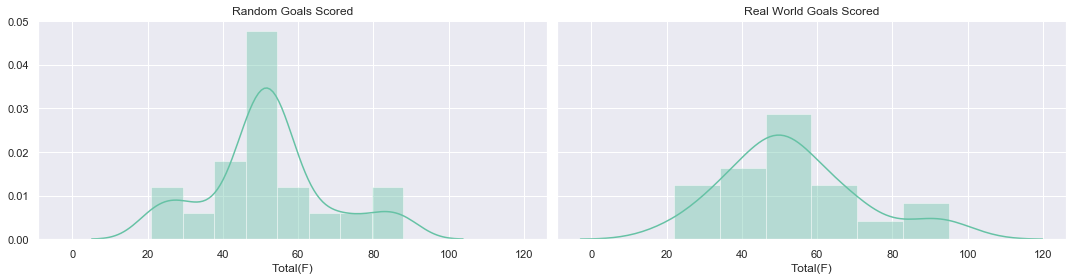

In [79]:
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distibution of randomly generated goals scored at home across the league
sns.distplot(total_new["Total(F)"], ax=axes[0])
axes[0].set_title("Random Goals Scored");

# distribution of real world goals scored at home 
sns.distplot(total["Total(F)"], ax=axes[1])
axes[1].set_title("Real World Goals Scored");

plt.tight_layout()

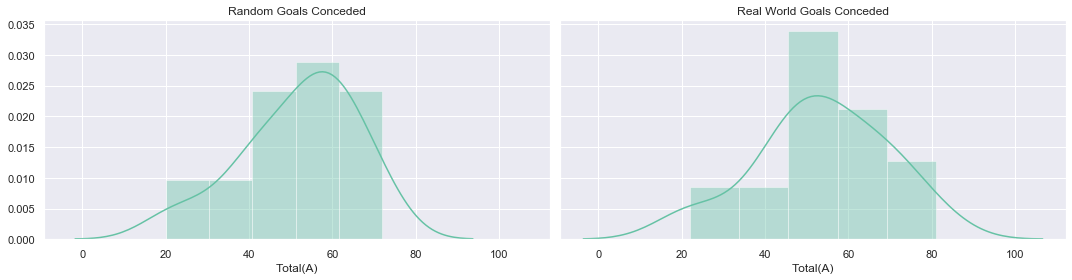

In [80]:
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distibution of randomly generated goals scored at home across the league
sns.distplot(total_new["Total(A)"], ax=axes[0])
axes[0].set_title("Random Goals Conceded");

# distribution of real world goals scored at home 
sns.distplot(total["Total(A)"], ax=axes[1])
axes[1].set_title("Real World Goals Conceded");

plt.tight_layout()

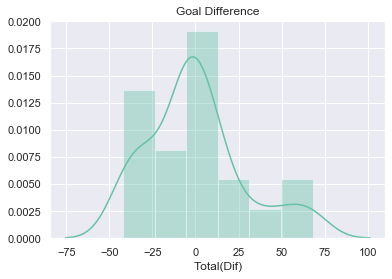

In [55]:
# distribution of goal difference
sns.distplot(total_new["Total(Dif)"])
plt.title("Goal Difference");

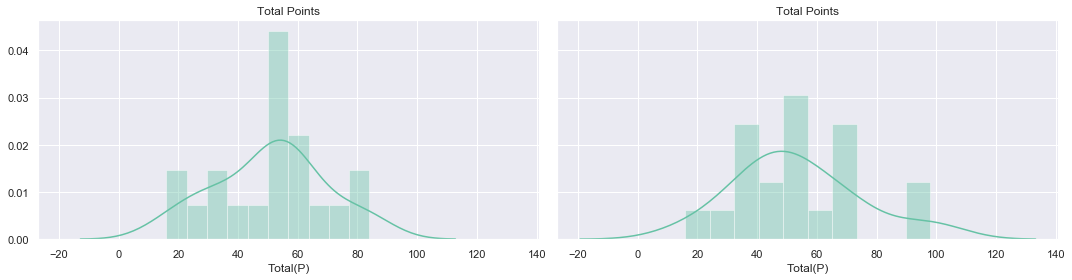

In [81]:
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of randomly generated total points
sns.distplot(total_new["Total(P)"], bins = 10, ax=axes[0])
axes[0].set_title("Total Points");

# distribution of real world total points
sns.distplot(total["Total(P)"], bins = 10, ax=axes[1])
axes[1].set_title("Total Points");

plt.tight_layout()

In [57]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

from scipy.stats import shapiro

stat, p = shapiro(total_new["Total(P)"])

alpha = 0.05

if p > alpha:
    print("Points Distribution appears to be Gaussian")
else:
    print("Points distribution does not appear to be Gaussian")

Points Distribution appears to be Gaussian


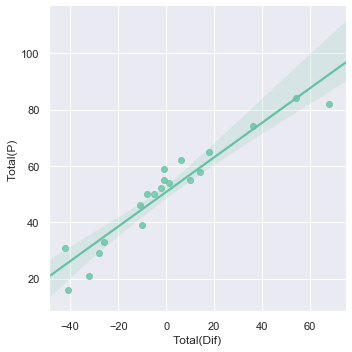

In [58]:
# regression plot between goal difference and total points
sns.lmplot(x="Total(Dif)", y="Total(P)", data=total_new);

## Home vs Away

In [59]:
# created league table based on home form
home_new = pl_new[["Home(F)", "Home(A)", "Home(Dif)", "Points(H)"]]
# sorted league table by points
home_new = home_new.sort_values(by = "Points(H)", ascending=False);
home_new

,Home(F),Home(A),Home(Dif),Points(H)
Team,,,,
Liverpool,57,9,48,43
Manchester City,46,13,33,42
Chelsea,39,13,26,38
Tottenham,36,16,20,36
Arsenal,37,19,18,34
Everton,31,23,8,33
Leicester City,22,17,5,32
Newcastle United,36,28,8,32
Bournemouth,25,21,4,31


In [60]:
# description of home dataframe
home_new.describe()

,Home(F),Home(A),Home(Dif),Points(H)
count,20.000000,20.000000,20.000000,20.00000
mean,28.100000,23.800000,4.300000,25.45000
std,11.497826,8.563079,17.314734,11.98453
min,9.000000,9.000000,-18.000000,4.00000
25%,21.000000,16.750000,-7.250000,17.75000
50%,25.000000,22.000000,0.500000,27.50000
75%,36.000000,33.000000,10.500000,33.25000
max,57.000000,35.000000,48.000000,43.00000


In [61]:
# created league table based on away form
away_new = pl_new[["Away(F)", "Away(A)", "Away(Dif)", "Points(A)"]]
# sorted league table by points
away_new = away_new.sort_values(by="Points(A)", ascending=False);
away_new

,Away(F),Away(A),Away(Dif),Points(A)
Team,,,,
Manchester City,35,14,21,42
Liverpool,31,11,20,39
Tottenham,36,20,16,38
Everton,27,17,10,32
Wolves,27,26,1,32
Leicester City,25,24,1,30
West Ham,23,23,0,28
Watford,22,24,-2,25
Arsenal,27,31,-4,24


In [62]:
# description of away dataframe
away_new.describe()

,Away(F),Away(A),Away(Dif),Points(A)
count,20.000000,20.000000,20.000000,20.000000
mean,23.800000,28.100000,-4.300000,25.300000
std,7.402702,8.872785,13.981567,8.272338
min,12.000000,11.000000,-35.000000,12.000000
25%,16.750000,23.000000,-14.000000,21.750000
50%,24.000000,29.500000,-4.500000,24.000000
75%,28.000000,33.500000,1.000000,30.500000
max,36.000000,47.000000,21.000000,42.000000


In [63]:
# ordered real world home and away tables by total points to compare with random tables
home = home.sort_values(by = "Points(H)", ascending=False);
away = away.sort_values(by = "Points(A)", ascending=False);

### Goals Scored 

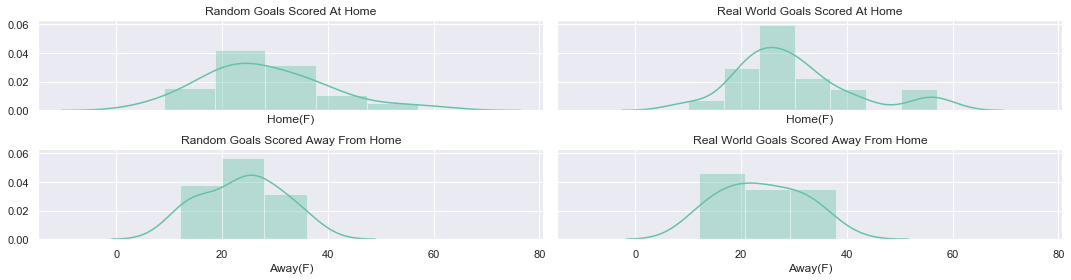

In [64]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of randomly generated goals scored at home
sns.distplot(home_new["Home(F)"], ax=axes[0,0])
axes[0,0].set_title("Random Goals Scored At Home");

# distribution of real world goals scored at home
sns.distplot(home["Home(F)"], ax=axes[0,1])
axes[0,1].set_title("Real World Goals Scored At Home");

# distibution of goals scored away from home across the league
sns.distplot(away_new["Away(F)"], ax= axes[1,0])
axes[1,0].set_title("Random Goals Scored Away From Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Away(F)"], ax= axes[1,1])
axes[1,1].set_title("Real World Goals Scored Away From Home");


plt.tight_layout()

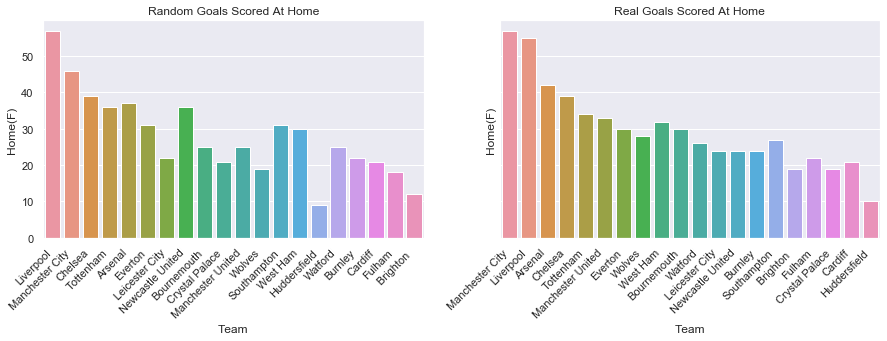

In [65]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals scored at home
goals_for = sns.catplot(x="Team", y="Home(F)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Scored At Home");

# distibution of real goals scored at home 
goals_for = sns.catplot(x="Team", y="Home(F)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Scored At Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)


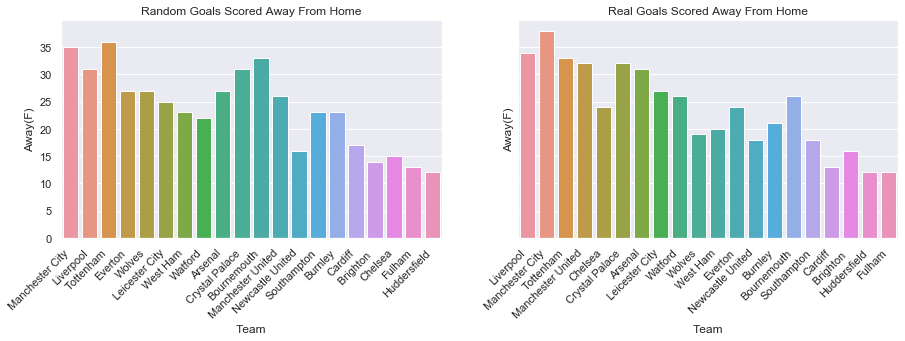

In [66]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals scored away from home
goals_for = sns.catplot(x="Team", y="Away(F)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Scored Away From Home");

# distibution of real goals scored away from home  
goals_for = sns.catplot(x="Team", y="Away(F)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Scored Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)


### Goals Conceded 

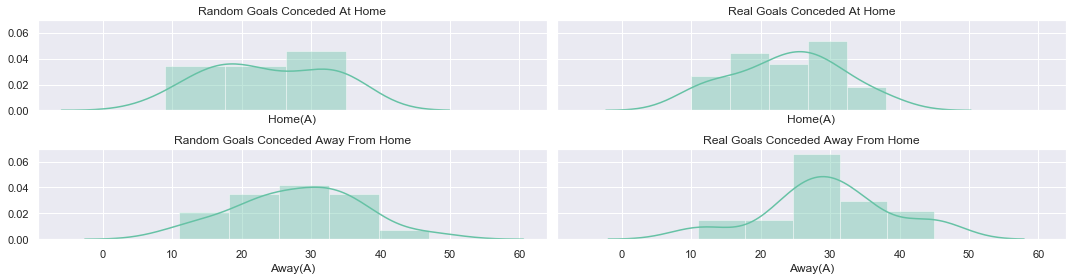

In [67]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of randomly generated goals conceded at home
sns.distplot(home_new["Home(A)"], ax=axes[0,0])
axes[0,0].set_title("Random Goals Conceded At Home");

# distribution of real world goals conceded at home
sns.distplot(home["Home(A)"], ax=axes[0,1])
axes[0,1].set_title("Real Goals Conceded At Home");

# distibution of randomly generated goals conceded away from home 
sns.distplot(away_new["Away(A)"], ax= axes[1,0])
axes[1,0].set_title("Random Goals Conceded Away From Home");

# distibution of real generated goals conceded away from home 
sns.distplot(away["Away(A)"], ax= axes[1,1])
axes[1,1].set_title("Real Goals Conceded Away From Home");

plt.tight_layout()

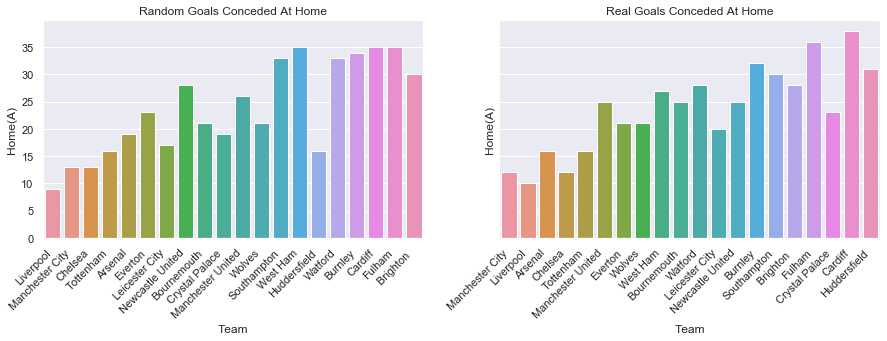

In [68]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals conceded at home
goals_for = sns.catplot(x="Team", y="Home(A)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Conceded At Home");

# distibution of real goals conceded at home 
goals_for = sns.catplot(x="Team", y="Home(A)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Conceded At Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

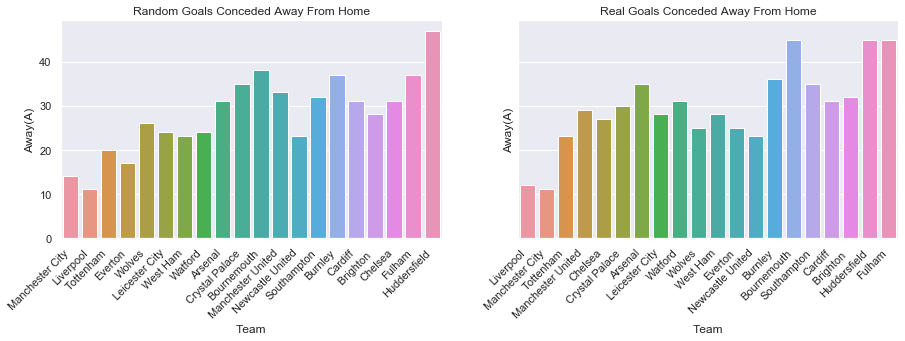

In [69]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals conceded away from home
goals_for = sns.catplot(x="Team", y="Away(A)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Conceded Away From Home");

# distibution of real goals conceded away from home 
goals_for = sns.catplot(x="Team", y="Away(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Conceded Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

### Goal Difference 

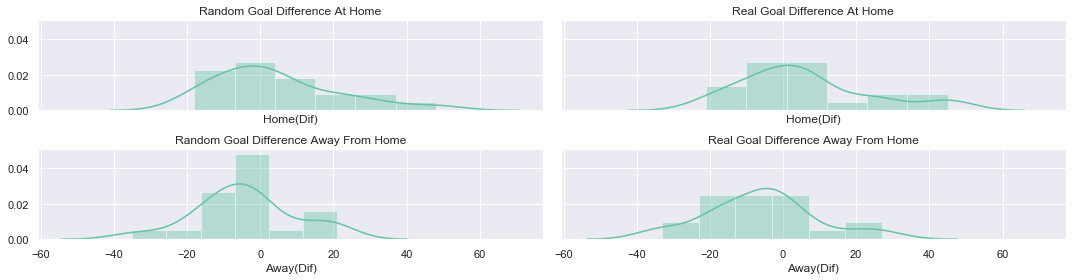

In [70]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of randomly goal difference at home
sns.distplot(home_new["Home(Dif)"], ax=axes[0,0])
axes[0,0].set_title("Random Goal Difference At Home");

# distribution of real world goal difference at home
sns.distplot(home["Home(Dif)"], ax=axes[0,1])
axes[0,1].set_title("Real Goal Difference At Home");

# distibution of randomly generated goal difference away from home 
sns.distplot(away_new["Away(Dif)"], ax= axes[1,0])
axes[1,0].set_title("Random Goal Difference Away From Home");

# distibution of real goal difference away from home 
sns.distplot(away["Away(Dif)"], ax= axes[1,1])
axes[1,1].set_title("Real Goal Difference Away From Home");

plt.tight_layout()

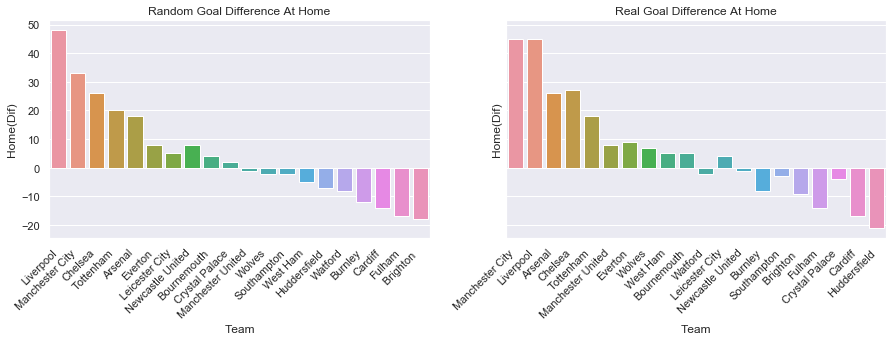

In [71]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goal difference at home
goals_for = sns.catplot(x="Team", y="Home(Dif)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goal Difference At Home");

# distibution of real goal difference at home 
goals_for = sns.catplot(x="Team", y="Home(Dif)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goal Difference At Home");

plt.tight_layout()

# closed empty plots  
plt.close(2)
plt.close(3)

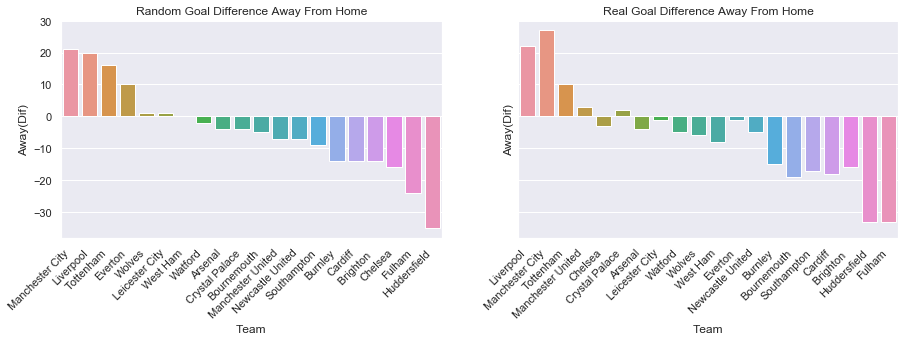

In [72]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goal difference away from home
goals_for = sns.catplot(x="Team", y="Away(Dif)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goal Difference Away From Home");

# distibution of real goal difference away from home 
goals_for = sns.catplot(x="Team", y="Away(Dif)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goal Difference Away From Home");

plt.tight_layout()

# closed empty plots  
plt.close(2)
plt.close(3)

### Points

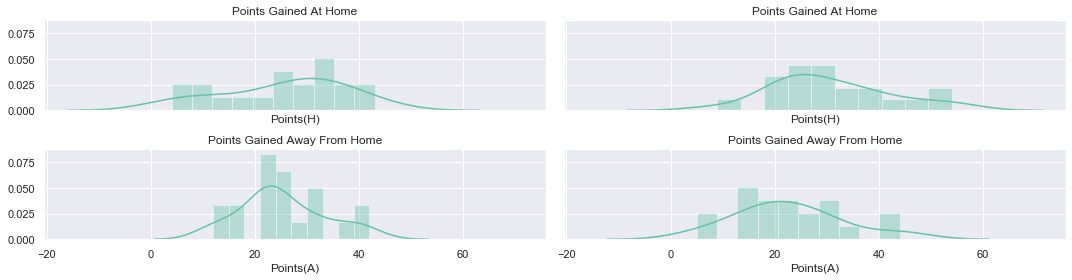

In [74]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of randomly generated points gained at home
sns.distplot(home_new["Points(H)"], bins= 10, ax=axes[0,0])
axes[0,0].set_title("Points Gained At Home");

# distribution of real points gained at home
sns.distplot(home["Points(H)"], bins= 10, ax=axes[0,1])
axes[0,1].set_title("Points Gained At Home");

# distibution of randomly generated points gained away from home
sns.distplot(away_new["Points(A)"], bins= 10, ax= axes[1,0])
axes[1,0].set_title("Points Gained Away From Home");

# distibution of real points gained away from home
sns.distplot(away["Points(A)"], bins= 10, ax= axes[1,1])
axes[1,1].set_title("Points Gained Away From Home");

plt.tight_layout()


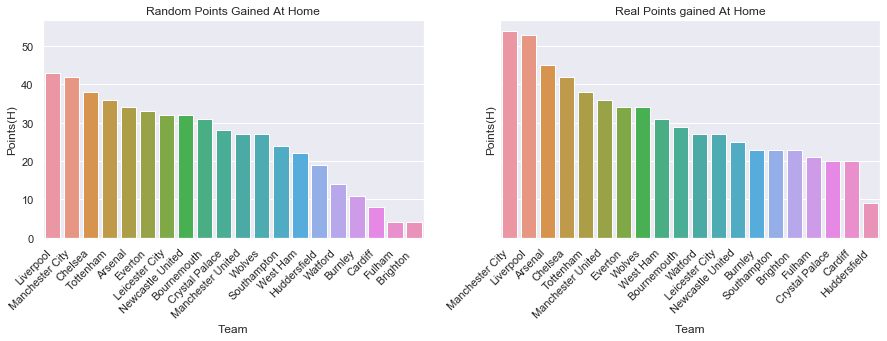

In [75]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# bar plot of random points gained at home
goals_for = sns.catplot(x="Team", y="Points(H)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Points Gained At Home");

# bar plot of real points gained at home 
goals_for = sns.catplot(x="Team", y="Points(H)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Points gained At Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

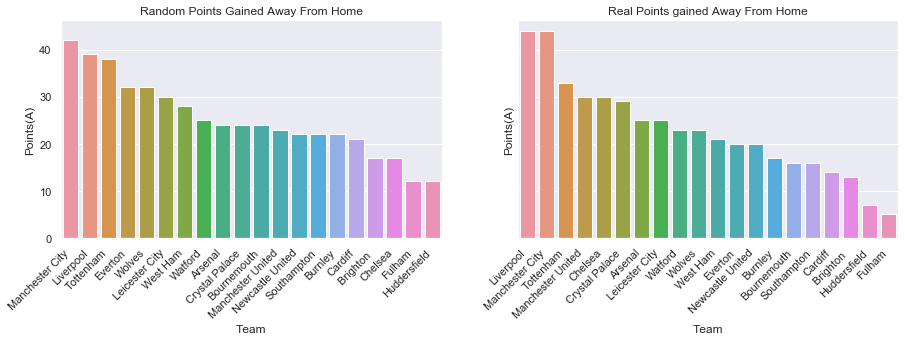

In [76]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# bar plot of random points gained away from  home
goals_for = sns.catplot(x="Team", y="Points(A)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Points Gained Away From Home");

# bar plot of real points gained away home 
goals_for = sns.catplot(x="Team", y="Points(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Points gained Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)